# **OK - Cupid**    💑💑💑

## **<span style="color: #006400">Measuring Regression Performance, Resampling, Parameter Tuning</span>**

**For this demonstration, the goal will be to predict whether a person’s profession is in the STEM fields (science, technology, engineering, and math).**

There is a moderate class imbalance in these data; only 18.5% of profiles work in these areas. In that case, when we perform resamples and splits, stratified cross-validation might be the better option.

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns

from scipy.misc import derivative

from plotnine import (ggplot, aes, geom_point, geom_smooth, 
                      geom_point, geom_abline, geom_line,
                      ggtitle, xlab, ylab)

# for setting plot size mainly
import plotnine.options as ggplot_options

#### **Loading the data**

In [406]:
okc_train_df = pd.read_csv("./data/OkCupid/okc_train.csv")
okc_test_df = pd.read_csv("./data/OkCupid/okc_test.csv")

print("Train set proportion: ")
print(okc_train_df['Class'].value_counts(normalize=True))
print("-----------------------------")
print("test set proportion: ")
print(okc_test_df['Class'].value_counts(normalize=True))

Train set proportion: 
other    0.815326
stem     0.184674
Name: Class, dtype: float64
-----------------------------
test set proportion: 
other    0.815273
stem     0.184727
Name: Class, dtype: float64


The data contains several types of variables:

* open text essays related to an individual’s interests and personal descriptions,
* single-choice type fields such as profession, diet, and education, and
* multiple-choice fields such as languages spoken and fluency in programming languages.

## **3.2 Measuring Performance**

### **3.2.1 Regression Metrics**

* RMSE - most common.
* $R^2$ is the proportion of the total variability in the outcome that can be explained by the model. One other advantage of this number is that it makes comparisons between different outcomes easy since it is unitless. Unfortunately, $R^2$ can be a deceiving metric. 
  - The main problem is that it is a measure of correlation and not accuracy. R-squared is the percentage of the dependent variable variation that the model explains. 
  - A second problem with using $R^2$ as a performance metric is that it can show very optimistic results when the outcome has large variance. 
  - Finally, $R^2$ can be misleading if there are a handful of outcome values that are far away from the overall scatter of the observed and predicted values. In this case the handful of points can artificially increase $R^2$



### **Example of a High $R^2$** coefficient

0.924978785797626

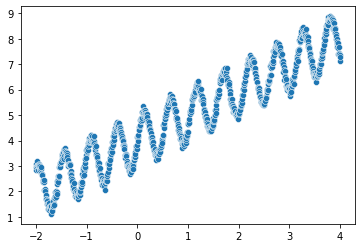

In [270]:
from scipy.stats import linregress
import matplotlib.pyplot as plt

n = 1000
x = np.linspace(-2, 4, n)
error = np.random.normal(0, 1/10, n)

y = 4 + x + np.sin(12 * x) + error
g = sns.scatterplot(x=x, y=y)
linregress(x, y).rvalue

### **Newton-Raphson method**

In [44]:
def find_root(f, epsilon=1e-3, start=np.random.uniform(-20, 20), max_iter=100):
    """Newton-Raphson method for finding a zero of a polynomial"""
    x = f(start)
    n = 0
    while abs(x) >= epsilon and n < max_iter:
        slope = derivative(f, x)
        x -= f(x) / slope
        n += 1
    return x

find_root(lambda x: x**2 + x**5 - x**3 - 0.2)

-1.296038821425519

<AxesSubplot:ylabel='Density'>

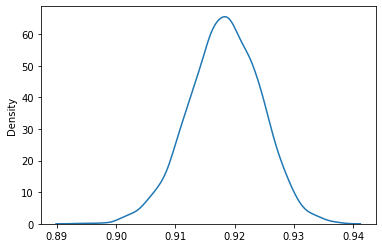

In [268]:
# Rsquared is biased
from scipy.stats import linregress
import matplotlib.pyplot as plt

n = 400
x = np.linspace(0, 10, n)
true_intercept = 2
true_slope = 0.8

def generate_r_value():
    error = np.random.normal(0, 1, n)
    y = true_intercept + true_slope * x + error

    return linregress(x, y).rvalue

rvals = [generate_r_value() for _ in range(1, 4000)]
sns.kdeplot(x=rvals)

#### **WHAT IS R-SQUARED?**

$$
R^2 = 1 - RSS / TSS
$$

$R^2$ is a biased but consistent estimator of how much the variance of the response $Y$ is explained by the model $\hat{Y}$. There's a true $R^2$ which is the limit of our estimator with $n \to \infty$. It only increases with more predictors.

#### **WHAT IS THE ADJUSTED R-SQUARED?**

The adjusted R-squared increases only if the new term improves the model more than would be expected by chance. It decreases when a predictor improves the model by less than expected by chance. 

$$
\bar{R}^2 := 1 - (1 - R^2)\frac{n-1}{n-p-1}
$$

#### **WHAT IS THE PREDICTED R-SQUARED?**

The predicted R-squared indicates how well a regression model predicts responses for new observations. This statistic helps you determine when the model fits the original data but is less capable of providing valid predictions for new observations.

**predictive R-squared = [1 - (PRESS / sums of squares total)] * 100**


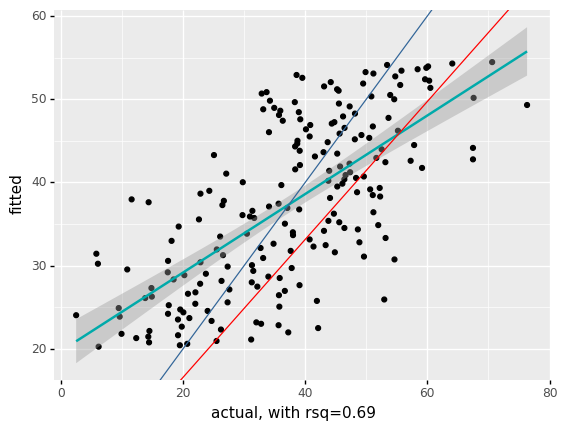

<ggplot: (317572371)>

In [380]:
from sklearn.linear_model import LinearRegression

x = np.linspace(0, 40, 200)
y = 20 + 0.8 * x + np.random.normal(0, 10, 200)

# sns.scatterplot(x, y)
df = pd.DataFrame({'x': x, 'y': y})

regression = LinearRegression()
regression.fit(df[['x']], df['y'])
lm = linregress(x, y)

fitted = regression.predict(df[['x']])

results = pd.DataFrame({'y': y, 'fitted': fitted})

lm = linregress(x, y)
# fitted = 

(ggplot(results) +
    aes(x='y', y='fitted') +
    geom_point() +
    geom_smooth(method='lm', color='#0aae') +
    geom_abline(slope=1, color='#336699') + 
    geom_abline(slope=np.sqrt(lm.rvalue), color='red') +
    xlab("actual, with rsq={:.2f}".format(lm.rvalue)) +
    ylab('fitted')
)

# sns.scatterplot(x=df['y'], y=predicted)



### **What is R-concordance correlation coefficient?**

This metric provides a measure of correlation relative to the line of agreement and is defined as the product of the usual correlation coefficient and a measure of bias from the line of agreement. The bias coefficient ranges from 0 to 1, where a value of 1 indicates that the data falls on the line of agreement. The further the data deviates from the line of agreement, the smaller the bias coefficient. Therefore, the CCC can be thought of as penalized version of the correlation coefficient. 

* Validity of a measurement - Are we really measuring what we mean to be measuring
* Reliability - How reliable a method is? Does it provide consistent results? Overfitting is lack of reliability for future observations. It doesn't mean it is measuring what we mean to measure, it means it's reliably and consistently measuring what it seems to be measuring.
* Test-retest reliability - consistent results from successive (in time) measurements taken with the exact same measure
* <span style="color: #cb997e">Inter-rater reliability</span> - Consistent results from different observers\raters, who are measuring the same thing.

## **Akaike information Criterion**

The Akaike information criterion (AIC) is an estimator of prediction error and thereby relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Thus, AIC provides a means for model selection.

AIC is founded on information theory. When a statistical model is used to represent the process that generated the data, the representation will almost never be exact; so some information will be lost by using the model to represent the process. AIC estimates the relative amount of information lost by a given model: the less information a model loses, the higher the quality of that model.

In estimating the amount of information lost by a model, AIC deals with the trade-off between the goodness of fit of the model and the simplicity of the model. In other words, AIC deals with both the risk of overfitting and the risk of underfitting.


### **Data Splitting And Resampling**


![Tux, the Linux mascot](./images/resampling.svg)

One way we can resample and split data when we have class imbalance is using a Strattified manner. That is, having a class, sample from the each class' observations.

In [538]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    okc_train_df.drop('Class', axis=1),
    okc_train_df['Class'],
    stratify=okc_train_df['Class'], 
    test_size=0.1
)

In [549]:
from sklearn.model_selection import RepeatedStratifiedKFold

rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=2)

for train_index, test_index in rskf.split(X_train, y_train):
    print(y_train.iloc[train_index].value_counts(normalize=True)[0])

0.8153344021988089
0.8153344021988089
0.8153344021988089
0.8153344021988089


Repeated Cross-Validation reduces the variance. Since more data are being averaged, the reduction in the variance of the final average would decrease by  $\sqrt{R}$ (using a Gaussian approximation). Again, the noisiness of this procedure is relative and, as one might expect, is driven by the amount of data in the assessment set.

### **Leave-one-out cross-validation**

**LOOCV** has the number of folds being equal to the size of the training set. This is a somewhat deprecated technique and may only be useful when the training set size is extremely small (Many folds).

### **Group-K-Fold**

We specify in what group every element falls and the same group will not appear in two different folds. Or, said another way, elements which are in the same group will appear in the same folds.

In [53]:
import numpy as np
from sklearn.model_selection import GroupKFold

X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
y = np.array([1, 2, 3, 4])

groups = np.array([0, 0, 2, 2])

group_kfold = GroupKFold(n_splits=2)
group_kfold.get_n_splits(X, y, groups)
[(X[i, :], X[j, :]) for i, j in group_kfold.split(X, y, groups)]

[(array([[1, 2],
         [3, 4]]),
  array([[5, 6],
         [7, 8]])),
 (array([[5, 6],
         [7, 8]]),
  array([[1, 2],
         [3, 4]]))]

### **Monte Carlo Cross-Validation** 🏎

Monte Carlo works somewhat differently. You randomly select (without replacement) some fraction of your data to form the training set, and then assign the rest of the points to the test set. This process is then repeated multiple times, generating (at random) new training and test partitions each time. For example, suppose you chose to use 10% of your data as test data. Then your test set on rep #1 might be points 64, 90, 63, 42, 65, 49, 10, 64, 96, and 48. On the next run, your test set might be 90, 60, 23, 67, 16, 78, 42, 17, 73, and 26. Since the partitions are done independently for each run, the same point can appear in the test set multiple times, which is the major difference between Monte Carlo and cross validation.

If you're attempting to do inference (i.e., statistically compare two algorithms), averaging the results of a 𝑘-fold cross validation run gets you a (nearly) unbiased estimate of the algorithm's performance, but with high variance (as you'd expect from having only 5 or 10 data points). Since you can, in principle, run it for as long as you want/can afford, Monte Carlo cross validation can give you a less variable, but more biased estimate.



In [ ]:
from sklearn.model_selection import ShuffleSplit

# creating a Monte Carlo K-Fold
shuffle_split = ShuffleSplit(n_splits=5)

for train_idx, test_idx in shuffle_split.split(X_train):
    print(train_idx)

Using this approach, there's no guarantee that the folds will be different.

### **3.4.3 The Bootstrap** 👢👢👢

The **bootstrap** resample is used as the analysis set and the assessment set, sometimes known as the **out-of-bag sample**, consists of the members of the training set not included in the bootstrap sample. As before, bootstrap sampling is **conducted B times** and the same modeling/evaluation procedure is followed to produce a bootstrap estimate of performance that is the mean of B results.



In [593]:
from sklearn.utils import resample

def get_resample(df):
    train_idx = resample(X_train.index)
    test_idx = np.setdiff1d(X_train.index, train_idx)
    return train_idx, test_idx

folds = [get_resample(df) for _ in range(10)]

# for train_idx, test_idx in folds:
#     print(train_idx)
#     print(test_idx)


### **3.4.4 Rolling Origin Forecasting** ⏲

This procedure is specific to time-series data or any data set with a strong temporal component (Hyndman and Athanasopoulos 2013). If there are seasonal or other chronic trends in the data, random splitting of data between the analysis and assessment sets may disrupt the model’s ability to estimate these patterns

![Tux, the Linux mascot](./images/ts-cv.svg)

### **Variance and Bias in Resampling**

Resampling methods have bias and variance properties, but their effects manifest in different ways. Variance is more straightforward to conceptualize. If you were to conduct 10-fold cross-validation many times on the same data set, the variation in the resampling scheme could be measured by determining the spread of the resulting averages.

#### Cross-Validation Error

Probably the simplest and most widely used method for estimating prediction error is **cross-validation**. This method directly estimates the expected out of sample error $$Err = E[L(Y, f(X))]$$

We might hope that cross-validation estimates the conditional error, with the training set T held fixed.

When $K=N$ (**LOOCV**) our estimation would be **unbiased**, but it would have **great variance** because the training sets would be very **similiar**, i.e. if we have another training set, the estimated out-of-sample error would be quite different.

<AxesSubplot:ylabel='Count'>

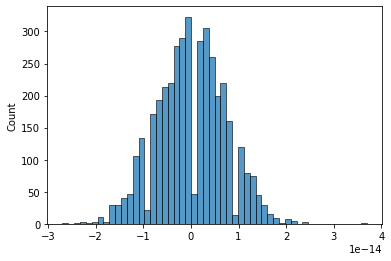

In [763]:
from sklearn.model_selection import KFold

X_train['something'] = np.random.uniform(0, 200, X_train.shape[0])

def mse(X_train, c, sample_size, n_splits, sample_rs, kfold_rs):
    X_tr = X_train.sample(n=sample_size, random_state=sample_rs)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=kfold_rs)
    res = [(X_tr.iloc[i][c].mean() - X_tr.iloc[j][c].mean()) for i, j in kf.split(X_tr)]
    return np.array(res).mean()
    

mses = [mse(X_train, 'something', 40, 10, None, None) for _ in range(4000)]
mses
sns.histplot(mses)
# np.var(error)

Generally speaking, as the amount of data in the analysis set shrinks, the resampling estimate’s bias increases. **In other words, the bias in 10-fold cross-validation is smaller than the bias in 5-fold cross-validation.**

In general, for a fixed training set size and number of resamples, simple V-fold cross-validation is generally believed to be the noisiest of the methods discussed here and the bootstrap is the least variable. The bootstrap is understood to be the most biased (since about 36.8% of the training set is selected for assessment) and its bias is generally pessimistic (i.e., likely to show worse model performance than the true underlying value). 

When the training set is not large, we recommend using **five** or so **repeats** of **10-fold cross-validation**, depending on the required precision, the training set size, and other factors.

### **What Should Be Included Inside of Resampling?**


❣️❣️❣️❣️❣️❣️❣️❣️❣️❣️

In order for any **resampling scheme** to produce performance estimates that generalize to new data, **<u style="color: #8B0000">it must contain all of the steps in the modeling process</u>** **that could significantly affect the model’s effectiveness**. 

❣️❣️❣️❣️❣️❣️❣️❣️❣️❣️


For example, in the first section, a transformation was used to modify the predictor variables and this resulted in an improvement in performance. During resampling, this step should be included in the resampling loop. 

Other preprocessing or filtering steps (such as PCA signal extraction, predictor correlation filters, feature selection methods) must be part of the resampling process in order to understand how well the model is doing and to measure when the modeling process begins to overfit.

<u>For small sets we did not include imputation, but in general imputation might affect the performance as well, so it should be added in the resampling schemes.</u>

* Downsampling ⏬
* Transformations 🐲
* Imputations 🤰

<u>Another consideration is Data-Leakage.</u> 🚰

To provide a solid methodology, one should constrain themselves to developing the list of preprocessing techniques, estimate them only in the presence of the training data points, and then apply the techniques to future data (including the test set).

<br/>
<br/>

 ## **Model Optimization and Tuning** 🔧🔧🔧

  The search for the best tuning parameter values can be done in many ways but most fall into two main categories:
  * predefine which values to evaluate
    - Grid search - Here, a set of candidate tuning parameter values are specified and then evaluated.
  * incrementally determine the values

We recommend using resampling to evaluate each distinct parameter value combination to get good estimates of how well each candidate performs.

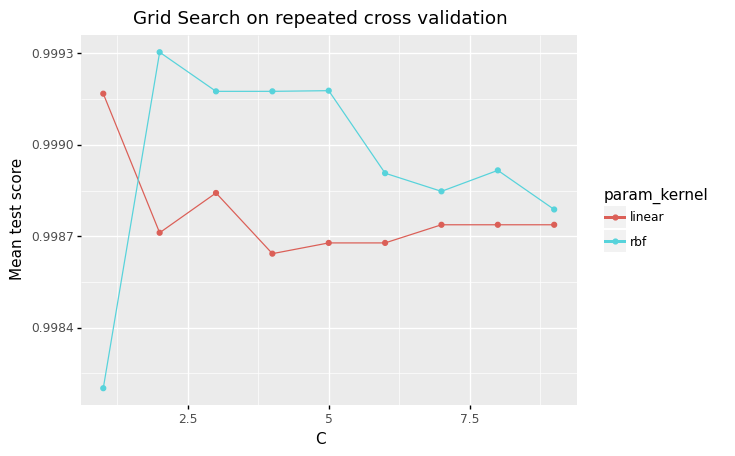

<ggplot: (314224354)>

In [854]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, roc_auc_score

# load the data
iris = datasets.load_iris()

# using a custom scoring function
scoring = make_scorer(roc_auc_score, needs_proba=True, multi_class="ovr")

# parameter grid search
parameters = {'kernel': ('linear', 'rbf'), 'C': np.arange(1, 10)}

# create classifier, grid searh and fit
# {'C': 2, 'kernel': 'rbf'}
svc = svm.SVC(probability=True)
clf = GridSearchCV(svc, parameters, cv=RepeatedKFold(n_splits=10, n_repeats=10), scoring=scoring)

clf.fit(iris.data, iris.target)

# create results df
results_df = pd.DataFrame(clf.cv_results_)
results_df['param_C'] = results_df['param_C'].astype(int)

# plot the lines plot
(ggplot(results_df) +
    aes(x='param_C', y='mean_test_score', color='param_kernel') +
    geom_point() + geom_line() +
    xlab("C") + ylab("Mean test score") + ggtitle("Grid Search on repeated cross validation")
)

In [855]:
clf.best_params_

{'C': 2, 'kernel': 'rbf'}

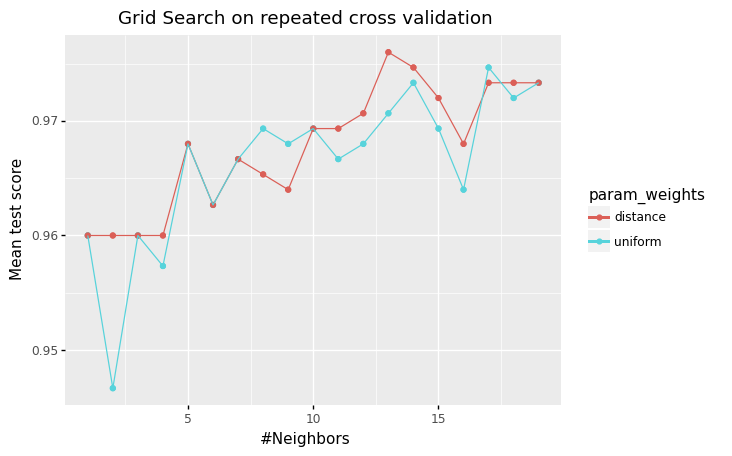

<ggplot: (319133790)>

In [846]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV, RepeatedKFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
iris = datasets.load_iris()

# TODO: KNN, SVM, model deployment, model serving

parameters = {
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'euclidean'),
    'n_neighbors': np.arange(1, 20)
}

knnc = KNeighborsClassifier()
clf = GridSearchCV(knnc, parameters, cv=RepeatedKFold(n_splits=10, n_repeats=5))
clf.fit(iris.data, iris.target)

results_df = pd.DataFrame(clf.cv_results_)
results_df['param_n_neighbors'] = results_df['param_n_neighbors'].astype(int)

(ggplot(results_df) +
    aes(x='param_n_neighbors', y='mean_test_score', color='param_weights') +
    geom_point() + geom_line() +
    xlab("#Neighbors") + ylab("Mean test score") + ggtitle("Grid Search on repeated cross validation")
)

The results are slightly better and less variable.

In [848]:
clf.best_params_

{'metric': 'minkowski', 'n_neighbors': 13, 'weights': 'distance'}

We can also use Random Grid Search. Neural networks, gradient boosting machines, and other models can effectively be tuned using this approach. 
In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter.

One final point about the interpretation of resampling results is that, by choosing the best settings based on the results and representing the model’s performance using these values, there is the risk of <span style="color: red">optimization bias</span>.

One Standard Error Rule: The One Standard Error Rule can be used to compare
models with different numbers of parameters in order to select the most parsimonious model
with low error. To use, find model with minimum error, then select the simplest model
whose mean falls within 1 standard deviation of the minimum.

![](./images/1-se-rule.png)